In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
df = pd.read_json('1_ecommerce.jsonl', lines=True)

In [3]:
df.head()

,session,events
0,12899779,"[{'aid': 59625, 'ts': 1661724000278, 'type': '..."
1,12899780,"[{'aid': 1142000, 'ts': 1661724000378, 'type':..."
2,12899781,"[{'aid': 141736, 'ts': 1661724000559, 'type': ..."
3,12899782,"[{'aid': 1669402, 'ts': 1661724000568, 'type':..."
4,12899783,"[{'aid': 255297, 'ts': 1661724000572, 'type': ..."


In [4]:
# for each session, we will create a list of items that the user has clicked on, removing duplicates
events_list = []
for i in df.events:
    clicks = []
    for j in i:
        if j['type'] == 'clicks':
            clicks.append(j['aid'])
    # remove duplicates from clicks
    clicks = set(clicks)
    events_list.append(list(clicks))

In [5]:
df['items'] = events_list
df = df.drop(columns=["events"], axis=1)

In [6]:
df.head()

,session,items
0,12899779,[59625]
1,12899780,"[1142000, 736515, 582732, 973453]"
2,12899781,"[199008, 57315, 141736, 918667, 194067]"
3,12899782,"[1344773, 987399, 413962, 975116, 740494, 7942..."
4,12899783,"[255297, 1114789, 1817895, 198385, 1729553, 17..."


In [7]:
print("Number of sessions: ", len(df))

Number of sessions:  1671803


In [8]:
items = df['items'].tolist()
# unique items
unique_items = list(set([item for sublist in items for item in sublist]))
print("Number of unique items: ", len(unique_items))

Number of unique items:  773736


# Preprocessing

## Number of clicks per session

In [9]:
df["num_click"] = df["items"].apply(lambda x: len(x))

In [10]:
df.head()

,session,items,num_click
0,12899779,[59625],1
1,12899780,"[1142000, 736515, 582732, 973453]",4
2,12899781,"[199008, 57315, 141736, 918667, 194067]",5
3,12899782,"[1344773, 987399, 413962, 975116, 740494, 7942...",32
4,12899783,"[255297, 1114789, 1817895, 198385, 1729553, 17...",9


In [11]:
df["num_click"].describe()

count    1.671803e+06
mean     2.946550e+00
std      5.018034e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      4.330000e+02
Name: num_click, dtype: float64

In [12]:
df[df["num_click"] == 0].sum()

session      22055817353
items                 []
num_click              0
dtype: object

In [13]:
df["session"].duplicated().sum()

0

## Remove sessions with no clicks

In [14]:
df = df[df["num_click"] > 0]

In [15]:
# top-5 sessions with the most number of clicks
df.sort_values(by='num_click', ascending=False).head()

,session,items,num_click
452579,13352358,"[505870, 155664, 102416, 215056, 403477, 84789...",433
334440,13234219,"[1785861, 1595399, 716815, 1058836, 1417248, 8...",407
327293,13227072,"[1505288, 1808398, 215056, 1400856, 471073, 71...",373
1472888,14372667,"[102416, 215056, 847895, 55331, 1855525, 17797...",334
290774,13190553,"[505870, 155664, 102416, 403477, 847895, 18555...",319


# Items Analysis

In [16]:
# count the number of times each item appears in the dataset
item_count = {}
for item_list in items:
    for item in item_list:
        if item in item_count:
            item_count[item] += 1
        else:
            item_count[item] = 1

## Most popular items

In [17]:
# top-50 most popular items
items_sorted = dict(sorted(item_count.items(), key=lambda x: x[1], reverse=True)[:30])

In [18]:
items_sorted.keys()

dict_keys([1460571, 108125, 485256, 986164, 754412, 554660, 832192, 1551213, 1006198, 184976, 579690, 29735, 33343, 329725, 819288, 861401, 1751274, 659399, 1019736, 496180, 1022566, 717965, 471073, 688602, 959208, 95488, 1604220, 1264313, 1497089, 337471])

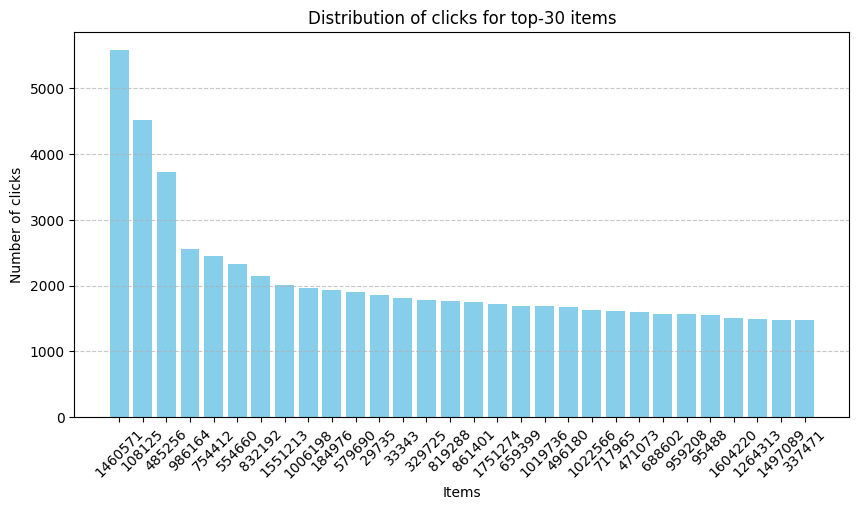

In [19]:
plt.figure(figsize=(10, 5))
plt.bar([str(k) for k in items_sorted.keys()], items_sorted.values(), color='skyblue')

# Labels and title
plt.xlabel("Items")
plt.ylabel("Number of clicks")
plt.title("Distribution of clicks for top-30 items")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.show()

In [20]:
# average number of clicks per item
avg_clicks = sum(item_count.values())/len(item_count)
print("Average number of clicks per item: ", avg_clicks)

Average number of clicks per item:  6.366578522907038


In [21]:
# items clicked only once
items_once = [k for k, v in item_count.items() if v == 1]
print("Number of items clicked only once: ", len(items_once))

Number of items clicked only once:  337405


# Most Common Item Sequences – Frequently occurring sequences of clicks (e.g., A -> B )

In [22]:
# most common different item sequences
sequences = []
for item_list in items:
    for i in range(len(item_list)-1):
        if item_list[i] != item_list[i+1]:
            sequences.append((item_list[i], item_list[i+1]))

In [23]:
# count the number of times each sequence appears in the dataset
sequence_count = Counter(sequences)

In [24]:
# top-30 most common sequences
sequences_sorted = dict(sorted(sequence_count.items(), key=lambda x: x[1], reverse=True)[:30])

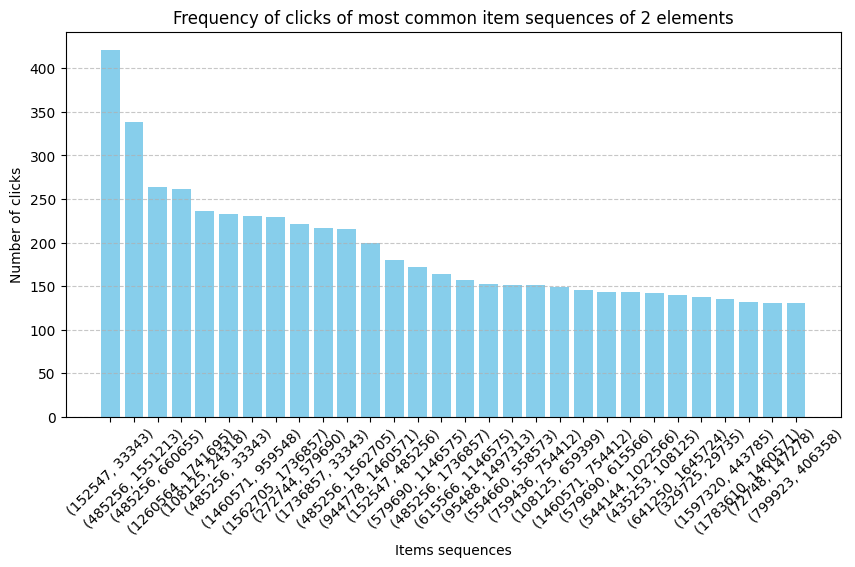

In [25]:
plt.figure(figsize=(10, 5))
plt.bar([str(k) for k in sequences_sorted.keys()], sequences_sorted.values(), color='skyblue')

# Labels and title
plt.xlabel("Items sequences")
plt.ylabel("Number of clicks")
plt.title("Frequency of clicks of most common item sequences of 2 elements")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Most Common Item Sequences – Frequently occurring sequences of clicks (e.g., A -> B -> C).

In [26]:
# sequence elements of more than 3 elements
bigger_sequences = []
for item_list in items:
    for i in range(len(item_list)-1):
        if len(item_list[i:]) >= 3:
            bigger_sequences.append((item_list[i], item_list[i+1], item_list[i+2]))

In [27]:
bigger_sequences_count = Counter(bigger_sequences)

In [28]:
# top-30 most common sequences
bigger_sequences_sorted = dict(sorted(bigger_sequences_count.items(), key=lambda x: x[1], reverse=True)[:30])

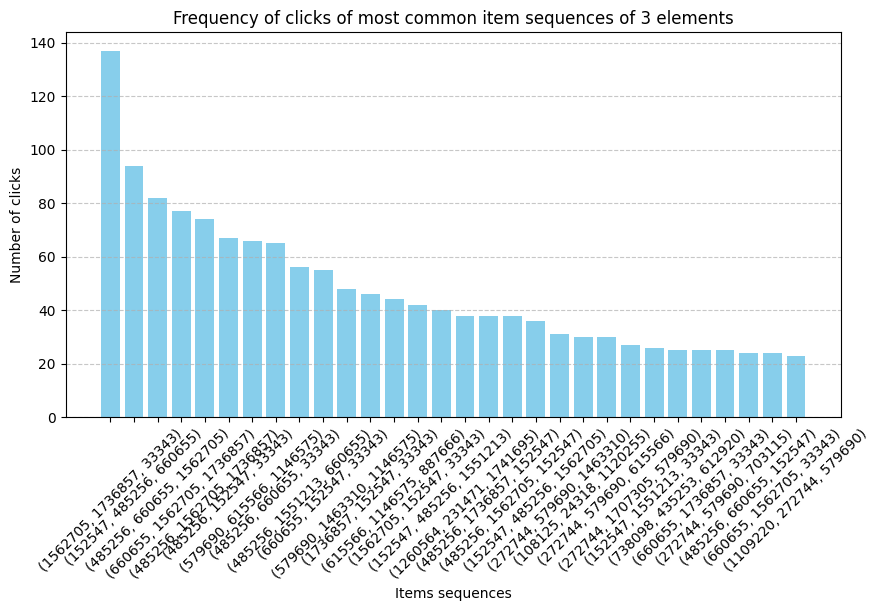

In [29]:
plt.figure(figsize=(10, 5))
plt.bar([str(k) for k in bigger_sequences_sorted.keys()], bigger_sequences_sorted.values(), color='skyblue')

# Labels and title
plt.xlabel("Items sequences")
plt.ylabel("Number of clicks")
plt.title("Frequency of clicks of most common item sequences of 3 elements")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()